##![LearnAI Header](https://coursematerial.blob.core.windows.net/assets/LearnAI_header.png)

# Classification using Automated ML

In this example we use Azure ML's Automated ML functionality to improve on the classifier we built earlier. Automated ML handles the task of building many models from a wide variety of algorithms and choosing a good set of hyper-parameters for them. We then select best the model (or one that meets our criteria) and deploy it as a web service.

## Load and prepare experiment

As part of the setup we have already created an AML workspace. Let's load the workspace and create an experiment.

In [5]:
import json
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn import datasets

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

We load the workspace directly from the config file we created in the early part of the course.

In [7]:
config_path = '/dbfs/tmp/aml_config'
ws = Workspace.from_config(path=os.path.join(config_path, 'config.json'))

experiment_name =  'pred-maint-automl' # choose a name for experiment
project_folder = '.' # project folder

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

Found the config file in: /dbfs/tmp/aml_config/config.json
Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.
Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code BVZNJ2DDN to authenticate.
Interactive authentication successfully completed.
 Out[ 2 ]: 
 
Experiment Name pred-maint-automl 
Location westus2 
Project Directory . 
Resource Group adb_airlift_rg 
SDK version 1.0.17 
Subscription ID 5be49961-ea44-42ec-8021-b728be90d58c
Workspace myADBworkspace

Opt in for diagnostics for better experience, quality, and security of future releases:

In [9]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on.

## Instantiate config file

We now instantiate a `AutoMLConfig` object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize.<br> Classification supports the following primary metrics <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>balanced_accuracy</i><br><i>average_precision_score_weighted</i><br><i>precision_score_weighted</i>|
|**max_time_sec**|Time limit in seconds for each iterations|
|**iterations**|Number of iterations. In each iteration Auto ML trains the data with a specific pipeline|
|**n_cross_validations**|Number of cross validation splits|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification.  This should be an array of integers. |
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. |

In [12]:
df = spark.read.parquet("dbfs:/FileStore/tables/preprocessed").cache()
display(df)

machineID datetime age diff_error_0 diff_error_1 diff_error_2 diff_error_3 diff_error_4 diff_fail_0 diff_fail_1 diff_fail_2 diff_fail_3 diff_maint_0 diff_maint_1 diff_maint_2 diff_maint_3 pressure_ma_3 pressure_sd_3 rotate_ma_3 rotate_sd_3 vibration_ma_3 vibration_sd_3 volt_ma_3 volt_sd_3 y_0 y_1 y_2 y_3 32 2015-02-23T21:00:00.000+0000 15 1095.0 166.0 409.0 1387.0 375.0 1071.0 1387.0 1387.0 351.0 711.0 1387.0 1387.0 351.0 99.47241720086753 4.027627389831299 451.38980736669623 37.143235255898006 36.437978246330076 5.246946040863718 175.77508414243 27.49122867502091 0 0 0 0 32 2015-02-23T22:00:00.000+0000 15 1096.0 167.0 410.0 1388.0 376.0 1072.0 1388.0 1388.0 352.0 712.0 1388.0 1388.0 352.0 100.09894109745454 3.794141420379903 435.17321536069 39.335699599244414 39.2308973568302 4.176148610708063 180.83567404661 23.740298384283044 0 0 0 0 32 2015-02-23T23:00:00.000+0000 15 1097.0 168.0 411.0 1389.0 377.0 1073.0 1389.0 1389.0 353.0 713.0 1389.0 1389.0 353.0 99.54439890229081 3.4758830167295156 421.66272855994526 15.279105023168727 41.711212313841905 0.9869915716793245 169.48155636960098 21.844321498131357 0 0 0 0 32 2015-02-24T00:00:00.000+0000 15 1098.0 169.0 412.0 1390.0 378.0 1074.0 1390.0 1390.0 354.0 714.0 1390.0 1390.0 354.0 97.68908923167595 2.826179881000501 416.56100286652577 14.313070539126413 43.106649846394575 2.4962971618940304 168.40722316791698 19.978049808200037 0 0 0 0 32 2015-02-24T01:00:00.000+0000 15 1099.0 170.0 413.0 1391.0 379.0 1075.0 1391.0 1391.0 355.0 715.0 1391.0 1391.0 355.0 96.91916094721387 4.036157929664655 428.15124045533855 23.48933395357947 42.8987242528714 2.771261929609087 172.9402295425665 16.124035462907294 0 0 0 0 32 2015-02-24T02:00:00.000+0000 15 1100.0 171.0 414.0 1392.0 380.0 1076.0 1392.0 1392.0 356.0 716.0 1392.0 1392.0 356.0 98.60820305322397 6.429119080028224 444.72279625965575 26.725216590298036 43.55483208223855 2.8184999168524905 166.95757356868276 19.57722439213211 0 0 0 0 32 2015-02-24T03:00:00.000+0000 15 1101.0 172.0 415.0 1393.0 381.0 1077.0 1393.0 1393.0 357.0 717.0 1393.0 1393.0 357.0 97.75829917013185 6.35926449953383 455.000717946228 30.802700661866158 46.0032332920517 5.284176271790364 171.5146198226785 18.02024867702125 0 0 0 0 32 2015-02-24T04:00:00.000+0000 15 1102.0 173.0 416.0 1394.0 382.0 1078.0 1394.0 1394.0 358.0 718.0 1394.0 1394.0 358.0 97.46746997114926 6.507590246654807 464.63403314151725 13.781545445572954 44.00402649786548 6.376598773584249 163.08366794565802 10.130385844311215 0 0 0 0 32 2015-02-24T05:00:00.000+0000 15 1103.0 174.0 417.0 1395.0 383.0 1079.0 1395.0 1395.0 359.0 719.0 1395.0 1395.0 359.0 103.47412855441392 9.726682380322783 481.54989358335945 31.29419249089553 41.575592514816776 9.504942586795327 164.627163319354 11.547022705888775 0 0 0 0 32 2015-02-24T06:00:00.000+0000 15 1104.0 175.0 418.0 1396.0 384.0 1080.0 1396.0 1396.0 360.0 720.0 0.0 1396.0 360.0 99.97419460128005 10.652800910349333 479.901478683917 32.041360774820994 39.010816091632826 9.76504784353832 168.14560647024325 6.929237687861469 0 0 0 0 32 2015-02-24T07:00:00.000+0000 15 1105.0 176.0 419.0 1397.0 385.0 1081.0 1397.0 1397.0 361.0 721.0 1.0 1397.0 361.0 100.15029186129584 10.590187503163172 473.63710397233655 34.62769205772143 38.128255894736746 8.134506576865844 166.1216860768285 5.943283017058889 0 0 0 0 32 2015-02-24T08:00:00.000+0000 15 1106.0 177.0 420.0 1398.0 386.0 1082.0 1398.0 1398.0 362.0 722.0 2.0 1398.0 362.0 105.59552260317155 12.236447822042502 454.12252068263774 63.05700352942591 39.63127388398258 8.784108069084116 171.9152997095555 8.938354357467752 0 0 0 0 32 2015-02-24T09:00:00.000+0000 15 1107.0 178.0 421.0 1399.0 387.0 1083.0 1399.0 1399.0 363.0 723.0 3.0 1399.0 363.0 102.61894668943505 10.22717773099529 421.03645911387275 46.393118053659066 41.204853753850045 6.909775637265635 175.63122458995275 12.640437636121353 0 0 0 0 32 2015-02-24T10:00:00.000+0000 15 1108.0 179.0 422.0 1400.0 388.0 1084.0 1400.0 1400.0 364.0 724.0 4.0 1400.0 364.0 109.454989153943

In [13]:
from pandas import datetime
from pyspark.sql.functions import col, hour

# we sample every nth row of the data using the `hour` function
df_train = df.filter((col('datetime') < datetime(2015, 10, 1))) # & (hour(col('datetime')) % 3 == 0))
df_test = df.filter(col('datetime') > datetime(2015, 10, 15))

In [14]:
X_keep = ['diff_maint_1', 'diff_error_1', 'volt_sd_3', 'diff_fail_3', 'pressure_ma_3', 'pressure_sd_3', 'diff_fail_1', 'diff_fail_0', 'age', 'vibration_ma_3', 'rotate_ma_3', 'diff_error_2', 'diff_fail_2', 'diff_error_3', 'diff_maint_2', 'volt_ma_3', 'diff_maint_0', 'vibration_sd_3', 'diff_maint_3', 'rotate_sd_3', 'diff_error_0', 'diff_error_4']
Y_keep = ['y_1'] # ['y_0', 'y_1', 'y_2', 'y_3']

# for now, we convert the spark DataFrames to Pandas dataframes, 
# because at this point automated ML only supports the latter. 
# This will change soon though.
X_train = df_train.select(X_keep).toPandas() 
X_test = df_test.select(X_keep).toPandas() 
y_train = df_train.select(Y_keep).toPandas() 
y_test = df_test.select(Y_keep).toPandas() 

In [15]:
X_train.columns

Out[ 7 ]: 
Index(['diff_maint_1', 'diff_error_1', 'volt_sd_3', 'diff_fail_3',
 'pressure_ma_3', 'pressure_sd_3', 'diff_fail_1', 'diff_fail_0', 'age',
 'vibration_ma_3', 'rotate_ma_3', 'diff_error_2', 'diff_fail_2',
 'diff_error_3', 'diff_maint_2', 'volt_ma_3', 'diff_maint_0',
 'vibration_sd_3', 'diff_maint_3', 'rotate_sd_3', 'diff_error_0',
 'diff_error_4'],
 dtype='object')

Here are the metrics we can choose to optimize our model over.

In [17]:
azureml.train.automl.constants.Metric.CLASSIFICATION_PRIMARY_SET

Out[ 8 ]: 
{'AUC_weighted',
 'accuracy',
 'average_precision_score_weighted',
 'norm_macro_recall',
 'precision_score_weighted'}

Since we are using `automl` on top of Spark, we have an additional step to run before running the experiment: We use the `azureml.dataprep` API to turn the data from a Pandas DataFrame to a Dataflow. A Dataflow represents a series of lazily-evaluated, immutable operations on data.

In [19]:
%sh
rm -r /dbfs/dprep
mkdir /dbfs/dprep
mkdir /dbfs/dprep/tmp

In [20]:
import azureml.dataprep as dprep
from pyspark.sql.functions import rand

temp_location = '/dbfs/dprep/tmp'
X_dflow = dprep.read_pandas_dataframe(X_train, temp_folder = temp_location + '/X')
y_dflow = dprep.read_pandas_dataframe(y_train, temp_folder = temp_location + '/y')

We now set up a configuration file for the automated ML training experiment. It contains details for how the experiment should run.

In [22]:
num_iters = 15

automl_config = AutoMLConfig(task = 'classification', 
                             preprocess = False,
                             name = experiment_name,
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 15,
                             iterations = num_iters,
                             verbosity = logging.INFO,
                             spark_context = sc,
                             X = X_dflow,
                             y = y_dflow,
                             # validation_size = 0.10,
                             n_cross_validations = 3,
                             path = project_folder)

## Run training experiment

You can call the submit method on the experiment object and pass the run configuration. For Local runs the execution is synchronous. Depending on the data and number of iterations this can run for while.
You will see the currently running iterations printing to the console.

In [25]:
local_run = experiment.submit(automl_config, show_output = True)

Running on ADB cluster experiment pred-maint-automl.
Parent Run ID: AutoML_c333ee37-3a87-4e1d-9699-b6fb2a38761c
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION PIPELINE SAMPLING % DURATION METRIC BEST
 0 StandardScalerWrapper LightGBM 100.0000 0:01:57 0.9600 0.9600
 1 StandardScalerWrapper LightGBM 100.0000 0:02:03 0.9790 0.9790
 2 SparseNormalizer LightGBM 100.0000 0:01:54 0.9446 0.9790
 3 RobustScaler LightGBM 100.0000 0:01:51 0.9445 0.9790
 4 SparseNormalizer LightGBM 100.0000 0:04:44 0.9796 0.9796
 5 RobustScaler LightGBM 100.0000 0:01:51 0.9035 0.9796
 6 StandardScalerWrapper LightGBM 100.0000 0:02:24 0.9650 0.9796
 7 StandardScalerWrapper LightGBM 100.0000 0:01:50 0.9739 0.9796
 8 StandardScalerWrapper LightGBM 100.0000 0:01:44 0.9850 0.9850
 9 StandardScalerWrapper LightGBM 100.0000 0:03:09 0.9981 0.9981
 10 RobustScaler LogisticRegression 100.0000 0:02:14 0.8378 0.9981
 11 SparseNormalizer LightGBM 100.0000 0:03:40 0.9813 0.9981
 12 MaxAbsScaler LightGBM 100.0000 0:02:08 0.9918 0.9981
 13 StandardScalerWrapper LightGBM 100.0000 0:03:31 0.9942 0.9981
 14 Ensemble 100.0000 0:03:32 0.9950 0.9981

#### Portal URL for Monitoring Runs

The following will provide a link to the web interface to explore individual run details and status.

In [27]:
displayHTML("<a href={} target='_blank'>Your experiment in Azure Portal: {}</a>".format(local_run.get_portal_url(), local_run.id))

Your experiment in Azure Portal: AutoML_c333ee37-3a87-4e1d-9699-b6fb2a38761c

## Retrieve the Best Model

Below we select the best pipeline from our iterations. The *get_output* method on automl_classifier returns the best run and the fitted model for the last *fit* invocation. There are overloads on *get_output* that allow you to retrieve the best run and fitted model for *any* logged metric or a particular *iteration*.

In [29]:
best_run, fitted_model = local_run.get_output()

In [30]:
fitted_model

Out[ 15 ]: 
Pipeline(memory=None,
 steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f1c4fcfeb00>), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7f1c46387588>)])

We can see from the above results that `StandardScalerWrapper` was used to scale the features and a `LightGBMClassifier` was chosen as the best model based on the metric we defined. This of course does NOT automatically also make it the best model in production, but choosing the right model for production is beyond the scope of this course so we will not address it here.

### Hands-on lab

Run the following cell and go to the link provided under Details Page. This links will take us to the Azure portal. Examine the content of the page. Can you find what resource group this resource is under? What kind of resource is it?

In [34]:
displayHTML("<a href={} target='_blank'>Your experiment in Azure Portal: {}</a>".format(best_run.get_portal_url(), best_run.id))

Your experiment in Azure Portal: AutoML_c333ee37-3a87-4e1d-9699-b6fb2a38761c_9

In addition to choosing a good algorithm, the experiment also tuned hyper-parameters. So our model didn't just run with the default hyper-parameter values. Find out how we can get the chosen hyper-parameters from the `fitted_model` object. Describe the hyper-parameters you see. Which ones do you think are the most critical ones?

In [36]:
# write solution here

### End of lab

We can run the following code to get the hyper-parameters for the chosen model.

In [39]:
n_steps = len(fitted_model.steps)

for s in range(n_steps):
  print("Step: %s" % s)
  params = fitted_model.steps[s][1].get_params()
  print(params)


Step: 0
{'with_mean': True, 'copy': True, 'cls': <class 'sklearn.preprocessing.data.StandardScaler'>, 'with_std': True}
Step: 1
{'colsample_bytree': 0.1, 'subsample_freq': 0, 'verbose': -10, 'random_state': None, 'subsample_for_bin': 200000, 'n_jobs': 1, 'class_weight': None, 'min_child_weight': 0, 'num_leaves': 221, 'reg_lambda': 0.3684210526315789, 'objective': None, 'silent': True, 'importance_type': 'split', 'learning_rate': 0.0842121052631579, 'boosting_type': 'goss', 'subsample': 1, 'min_split_gain': 0.2631578947368421, 'min_child_samples': 7, 'max_bin': 120, 'reg_alpha': 0.5789473684210527, 'n_estimators': 200, 'max_depth': 8}

With a little bit of re-arranging we can pull out the metrics we're interested in and compare them across different runs. Since we're in Databricks, we can use `display` to create a quick visualization with the results.

In [41]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}    
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata['metric'] = rundata.index
rundata = rundata.reset_index()
res = rundata.melt(id_vars='metric', value_vars = range(num_iters))
display(res.loc[res.metric.str.contains('micro'), :]) # in this case we limit the metrics to the ones containing the word `micro`

metric variable value AUC_micro 0 0.9599648377171669 average_precision_score_micro 0 0.5861285814161922 f1_score_micro 0 0.982635197066911 precision_score_micro 0 0.982635197066911 recall_score_micro 0 0.982635197066911 AUC_micro 1 0.9789664393142831 average_precision_score_micro 1 0.682266308681794 f1_score_micro 1 0.9857699358386802 precision_score_micro 1 0.9857699358386802 recall_score_micro 1 0.9857699358386802 AUC_micro 2 0.9445615874546034 average_precision_score_micro 2 0.420154032165313 f1_score_micro 2 0.9811503208065995 precision_score_micro 2 0.9811503208065995 recall_score_micro 2 0.9811503208065995 AUC_micro 3 0.9444850659270457 average_precision_score_micro 3 0.48858456468215633 f1_score_micro 3 0.9811503208065995 precision_score_micro 3 0.9811503208065995 recall_score_micro 3 0.9811503208065995 AUC_micro 4 0.9795891660578465 average_precision_score_micro 4 0.6792179022928235 f1_score_micro 4 0.9867736021998167 precision_score_micro 4 0.9867736021998167 recall_score_micro 4 0.9867736021998167 AUC_micro 5 0.903513318996027 average_precision_score_micro 5 0.4002846302659391 f1_score_micro 5 0.9811503208065995 precision_score_micro 5 0.9811503208065995 recall_score_micro 5 0.9811503208065995 AUC_micro 6 0.9649609381064663 average_precision_score_micro 6 0.5987602330947185 f1_score_micro 6 0.9861778185151238 precision_score_micro 6 0.9861778185151238 recall_score_micro 6 0.9861778185151238 AUC_micro 7 0.9738745312265938 average_precision_score_micro 7 0.6187976917784658 f1_score_micro 7 0.9851894286587228 precision_score_micro 7 0.9851894286587228 recall_score_micro 7 0.9851894286587228 AUC_micro 8 0.985047249155754 average_precision_score_micro 8 0.6954225746538142 f1_score_micro 8 0.9859853345554536 precision_score_micro 8 0.9859853345554536 recall_score_micro 8 0.9859853345554536 AUC_micro 9 0.9981395907749718 average_precision_score_micro 9 0.960172827325321 f1_score_micro 9 0.9946333638863427 precision_score_micro 9 0.9946333638863427 recall_score_micro 9 0.9946333638863427 AUC_micro 10 0.8377936942006586 average_precision_score_micro 10 0.22968885793588423 f1_score_micro 10 0.8162939199511152 precision_score_micro 10 0.8162939199511152 recall_score_micro 10 0.8162939199511152 AUC_micro 11 0.9813464175990418 average_precision_score_micro 11 0.7223846123233127 f1_score_micro 11 0.987225786739994 precision_score_micro 11 0.987225786739994 recall_score_micro 11 0.987225786739994 AUC_micro 12 0.9918020048256944 average_precision_score_micro 12 0.8205954003042905 f1_score_micro 12 0.9899312557286893 precision_score_micro 12 0.9899312557286893 recall_score_micro 12 0.9899312557286893 AUC_micro 13 0.9942382119230335 average_precision_score_micro 13 0.8735798100660949 f1_score_micro 13 0.9912725328444852 precision_score_micro 13 0.9912725328444852 recall_score_micro 13 0.9912725328444852 AUC_micro 14 0.9949650296512225 average_precision_score_micro 14 0.9416562199975571 f1_score_micro 14 0.9920348304307974 precision_score_micro 14 0.9920348304307974 recall_score_micro 14 0.9920348304307974

Quick note: macro and micro averages are only relevant in a multi-class classification scenario. In this situation, we can compute a single classification metric (such as precison, recall or AUC) in one of two ways. Let's use precision to illustrate the difference. Recall that precision = TP / (TP + FP). In a multi-class classification setting, each class has a TP and FP, and hence a precision. So we can compute a macro and micro precision as such:
- We can compute precision *per class* and then average across all classes. This is called a **macro precision**. When class imbalances are strong macro averages are not recommended, because by taking a *simple* (not weighted) average we treat all classes equally.
- We can compute the aggregated value for TP and FS (summed up for all classes) and then compute an aggregated precision. This is called a **micro presicion** and it works better when we have imbalances across the classes.

## Score and evaluate the chosen model

Let's now pick the best model returned by the experiment and use it to get predictions for the test data. This is simply done by replacing `manual_model.predict` with `fitted_model.predict`.

In [45]:
y_pred = fitted_model.predict(X_test)

We should get the same confusion matrix we did in the section above.

In [47]:
confusion_matrix(y_test.values, y_pred)

Out[ 21 ]: 
array([[183874, 13],
 [ 3504, 409]])

We use `classification_report` to automatically calculate precision, recall, and the F-1 score from the confusion matrix above.

In [49]:
cl_report = classification_report(y_test.values, y_pred)
print(cl_report)

precision recall f1-score support

 0 0.98 1.00 0.99 183887
 1 0.97 0.10 0.19 3913

avg / total 0.98 0.98 0.97 187800

The AUC is just the area under the ROC curve shown here:

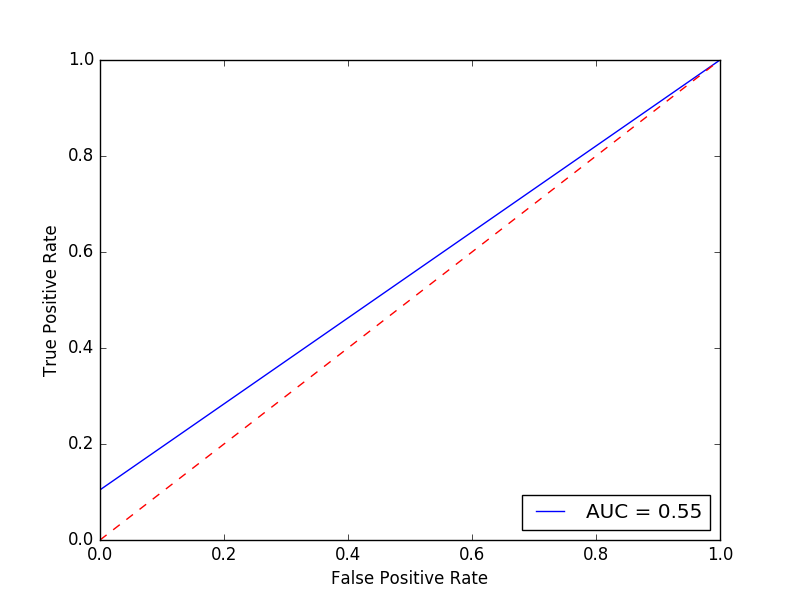

In [51]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'b', label = 'AUC = {0:.2f}'.format(roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
display()

## Register fitted model for deployment

Now that we have a model we're happy with, we register it to our Azure ML account. This will be the first step toward model management and deployment, which we cover in the next Notebook. Registered models can also be loaded into other workspaces.

In [54]:
description = 'automated ML PdM (predict y_1)'
tags = None
model = local_run.register_model(description=description, tags=tags)
local_run.model_id # Use this id to deploy the model as a web service in Azur

Registering model AutoMLc333ee373best
 Out[ 24 ]: 'AutoMLc333ee373best'

Optionally, we can also take the model and save it on disk as a pickle file, as shown here:

In [56]:
from sklearn.externals import joblib
joblib.dump(value=fitted_model, filename='model.pkl')

Out[ 25 ]: ['model.pkl']

In [57]:
# You can ignore this code, we use it for testing our notebooks.
assert isinstance(model, azureml.core.model.Model)

# The end

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.